In [2]:
#install required packages
import sys
!pip install atlasopenmagic
%pip install "pyarrow>=20.0.0"
# from atlasopenmagic import install_from_environment
# install_from_environment(environment_file="environment.yml")

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import re
import awkward as ak 
import vector
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator, AutoMinorLocator # for minor ticks

sys.path.append('./backend')
#from GetInputMagic import get_samples_magic
from ValidateVariables import validate_variables
from GetInput import get_samples # Build a dict that consists of the root files' name 
from PqRunAnalysis import analysis_parquet, get_data_new
from PqPlotHistogramAk import plot_histogram_new
from PqMultipleRuns import get_results_list, plot_multiple_runs

The string code for the available final-state collections:

* '2to4lep' - two to four leptons with at least 7 GeV of $p_T$ each
* '2muons' - at least two muons with at least 10 GeV of $p_T$
* 'GamGam' - at least two photons with at least 25 GeV of $p_T$ each
* 'exactly4lep' - exactly four leptons with at least 7 GeV of $p_T$

The string code for the available Monte Carlo simulation dataset:
* 'Zee'
* 'Zmumu'
* 'Ztautau'
* 'Wlepnu'
* 'ttbar'
* 'H'
* 'ZZllll'

Please use '+' to combine data sets. For example, if you want to combine the data for the physics processes of $Z\rightarrow\tau\tau$ and $ZZ^{*}\rightarrow llll$, write 'Ztautau+ZZllll'.

Please include '**Data**' in the key defined for the final-state collection and '**Signal**' for the physical processes simulated by the MC. Remember, strings in Python are case-sensitive! Please do not include 'Data' in the key if you don't want to store the real data as its value. Likewise, please avoid having 'Signal' in the key if it is not a Monte Carlo simulated data set that models the physics process that you want to study.
The functions defined to analyse and plot the data rely heavily on the presence of the keywords '**Data**' and '**Signal**'. Please see the scripts in the backend folder if you are interested in how the functions are defined. You are recommended not to modify the scripts in the backend folder.

In [4]:
keys_input = ['Background $Z→ee$, $W→lν$', 
              'Signal $Z→μμ$',
              'Data 2to4lep']

string_codes_input = ['Zee+Wlepnu', 
                      'Zmumu',
                      '2to4lep']


keys_input = ['Data 2to4lep', 'Signal $Z→μμ$']

string_codes_input = ['2to4lep', 'Zmumu']

In [4]:
samples = get_samples(keys_input, string_codes_input)
print(samples)

{'Data 2to4lep': {'files': ['./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodB.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodC.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodD.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodE.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodF.2to4lep.root', './backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodG.2to4lep.root', './backend

In [5]:
luminosity = 36.6
fraction = 0.01
# Define what variables are important to our analysis
variables = ["lep_n", "lep_pt", "lep_eta", "lep_phi", "lep_e", 
             #"lep_ptvarcone30", "lep_topoetcone20", 
             "lep_type", "lep_charge",
             #"lep_isLooseID", "lep_isMediumID", "lep_isTightID",
             #"lep_isLooseIso", "lep_isTightIso",
             #"trigE",
             "trigM", "lep_isTrigMatched"]


In [6]:
variables = validate_variables(variables)

In [7]:
# Note: first lepton in each event is [:, 0], 2nd lepton is [:, 1] etc
# Functions return bool. True means we should remove the event

# Function to cut on the number of leptons in each event
def cut_lep_n(lep_n, user_input):
    return (lep_n == user_input)

# Function to cut on the lepton type (based on type of first two lep_type)
# lep_type is a number signifying the lepton type (electron (11) or muon (13))
def cut_lep_type(lep_type, user_input):
    sum_lep_type = lep_type[:, 0] + lep_type[:, 1] # Sum of first two leptons' type in the event 
    return (sum_lep_type == user_input)

# Function to cut on the lepton charge (based on charge of first two lep_charge)
def cut_lep_charge(lep_charge, user_input):
    product_lep_charge = lep_charge[:, 0] * lep_charge[:, 1] # Product of first two leptons' charge in the event
    return (product_lep_charge == user_input)

# Function to cut on the lepton transverse momentum
def cut_lep_pt(lep_pt, index, lower_limit):
    return (lep_pt[:, index] > lower_limit) # Accept events with lepton pt higher than lower limit

# Function to cut on the isolation pt (based on first two leptons)
def cut_lep_ptvarcone30(lep_ptvarcone30, upper_limit):
    # Accept events with lep_ptvarcone30 in the range
    return (lep_ptvarcone30[:, 0] < upper_limit) & (lep_ptvarcone30[:, 1] < upper_limit)

# Function to cut on the isolation et (based on first two leptons)
def cut_lep_topoetcone20(lep_topoetcone20, upper_limit):
    # Accept events with lep_topoetcone20 in the range
    return (lep_topoetcone20[:, 0] < upper_limit) & (lep_topoetcone20[:, 1] < upper_limit)

# Function to accept events with at least one lepton is triggering
def cut_trig_match(lep_trigmatch): 
    return ak.sum(lep_trigmatch, axis=1) >= 1

# # Function to accept events that has been selected by any of the single electron OR muon triggers
# def cut_trig(trigE, trigM):
#     return trigE | trigM

# Function to accept events that has been selected by any of the single electron OR muon triggers
def cut_trig(trigM):
    return trigM

# # Function to filter events based on the identification and isolation criteria of all leptons in each event
# def ID_iso_cut(electron_isID, muon_isID, electron_isIso, muon_isIso, lep_type, lep_n): 
#     return (ak.sum(((lep_type == 13) & muon_isID & muon_isIso) | 
#                    ((lep_type == 11) & electron_isID & electron_isIso), axis=1) == lep_n)

# Function to keep events that have all leptons passed the identification and isolation criteria
def ID_iso_cut(lep_isID, lep_isIso, lep_n): 
    return (ak.sum(lep_isID & lep_isIso, axis=1) == lep_n)

# Function to calculate the invariant mass using four momentum (pt, eta, phi, energy)    
def calculate_inv_mass(lep_pt, lep_eta, lep_phi, lep_e):
    four_momentum = vector.zip({"pt": lep_pt, "eta": lep_eta, "phi": lep_phi, "E": lep_e})
    invariant_mass = (four_momentum[:, 0] + four_momentum[:, 1]).M

    return invariant_mass

def selection_cut(data):
    # Keep events that pass electron / muon trigger 
    data = data[cut_trig(data['trigM'])]
    # Keep events where at least one lepton is triggering
    data = data[cut_trig_match(data['lep_isTrigMatched'])]

    # Lepton cuts
    lep_n = data['lep_n']
    data = data[cut_lep_n(lep_n, 2)]
          
    lep_type = data['lep_type']
    data = data[cut_lep_type(lep_type, 26)]
    
    lep_charge = data['lep_charge']
    data = data[cut_lep_charge(lep_charge, -1)]
    
    # Invariant Mass
    data['mass'] = calculate_inv_mass(data['lep_pt'], data['lep_eta'], data['lep_phi'], data['lep_e'])

    return data

In [8]:
filename = 'pq-09-07-2025.txt'

analysis_parquet(luminosity, fraction, samples, selection_cut, variables,
                 ['lep_eta', 'lep_pt', 'mass', 'lep_phi', 'lep_type', 'lep_n'], filename)


Reminder: variable 'mass' will only be saved if it is computed and saved in the selection_cut function.
Processing Data 2to4lep samples
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodD.2to4lep.root:
		 nIn: 8802,	 nOut: 	570
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodE.2to4lep.root:
		 nIn: 65261,	 nOut: 	5011
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodF.2to4lep.root:
		 nIn: 41832,	 nOut: 	3067
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodG.2to4lep.root:
		 nIn: 93682,	 nOut: 	7944
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodH.2to4lep.root:
		 nIn: 28656,	 nOut: 	2816
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data15_periodJ.2to4lep.root:
		 nIn: 161720,	 nOut: 	16002
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodA.2to4lep.root:
		 nIn: 73689,	 nOut: 	5074
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_periodB.2to4lep.root:
		 nIn: 160015,	 nOut: 	15562
	./backend/datasets/ODEO_FEB2025_v0_2to4lep_data16_per

In [5]:
output_dir = 'output/lumi36.6_frac0.01_lep_etalep_ptmasslep_philep_typelep_n202507071721'
#mass = get_data_pq(keys_input, output_dir, 'mass')

In [6]:
run1 = get_data_new(keys_input, output_dir, ['lep_pt[0]', 'mass'])
run1

Elapsed time = 2.2s


{'Data 2to4lep': {'lep_pt[0]': <Array [39.4, 45.2, 33.8, 44.5, ..., 54.3, 35.6, 46.8] type='317512 * float32'>,
  'mass': <Array [96.5, 88, 58.4, 88.5, ..., 95.9, 88.8, 90] type='317512 * float32'>},
 'Signal $Z→μμ$': {'lep_pt[0]': <Array [101, 75.4, 59.2, 183, ..., 34.1, 78.3, 30.4] type='484134 * float32'>,
  'mass': <Array [91.7, 88.5, 92.9, 94.7, ..., 90, 99.9, 87.4] type='484134 * float32'>,
  'totalWeight': <Array [0.0388, 0.266, 0.616, ..., 0.00436, 0, 0.436] type='484134 * float64'>}}

In [7]:
output_dir = 'output/lumi36.6_frac0.01_lep_etalep_ptmasslep_philep_typelep_n202507091852'
run2 = get_data_new(keys_input, output_dir, ['lep_pt[1]', 'mass'])

Elapsed time = 0.6s


## Demonstration of plotting multiple variables

Elapsed time = 0.2s
Elapsed time = 0.4s


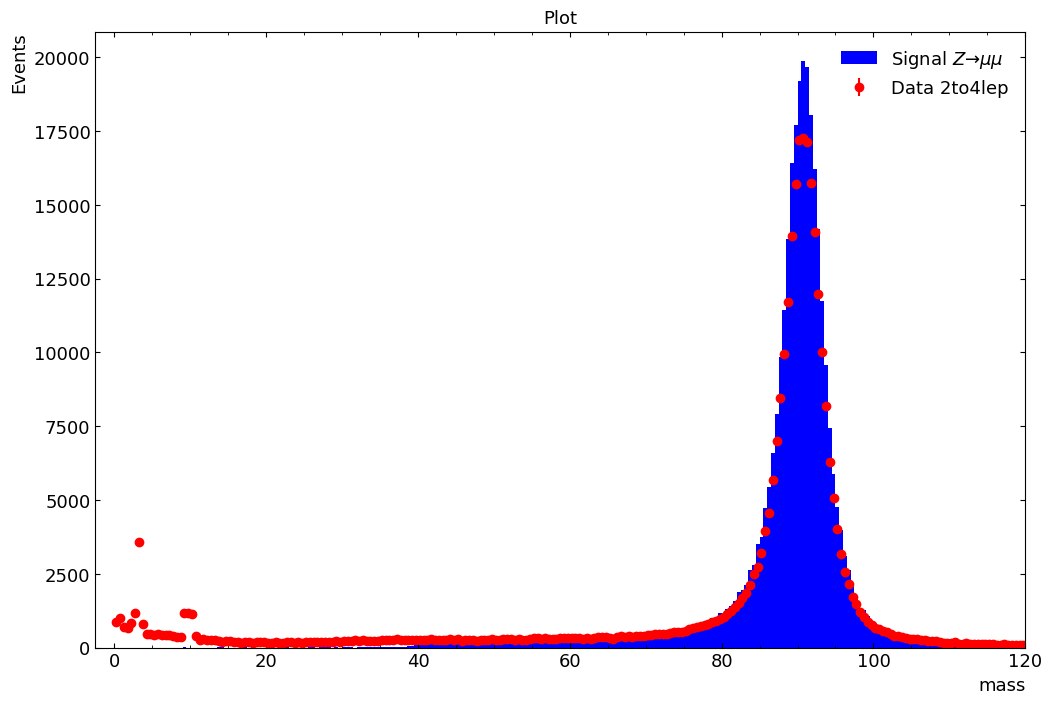

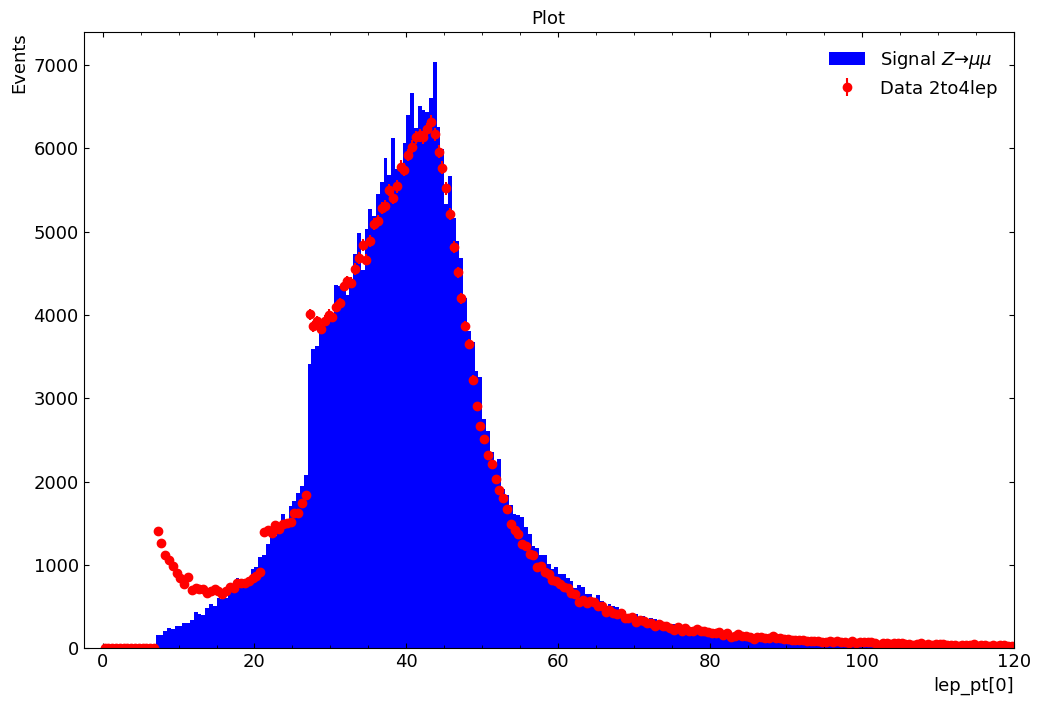

In [8]:
GeV = 1.0
# x-axis range of the plot
xmin = 0 * GeV
xmax = 120 * GeV
# Histogram bin setup
step_size = 0.5 * GeV

plot_histogram_new(run1,
                   ['mass', 'lep_pt[0]'],
                   ['r', 'b'],
                   (xmin, xmax),
                   0.5,
                   ['mass', 'lep_pt[0]'],
                   y_label_list=['Events','Events'], title_list=['Plot', 'Plot'])

Elapsed time = 0.2s


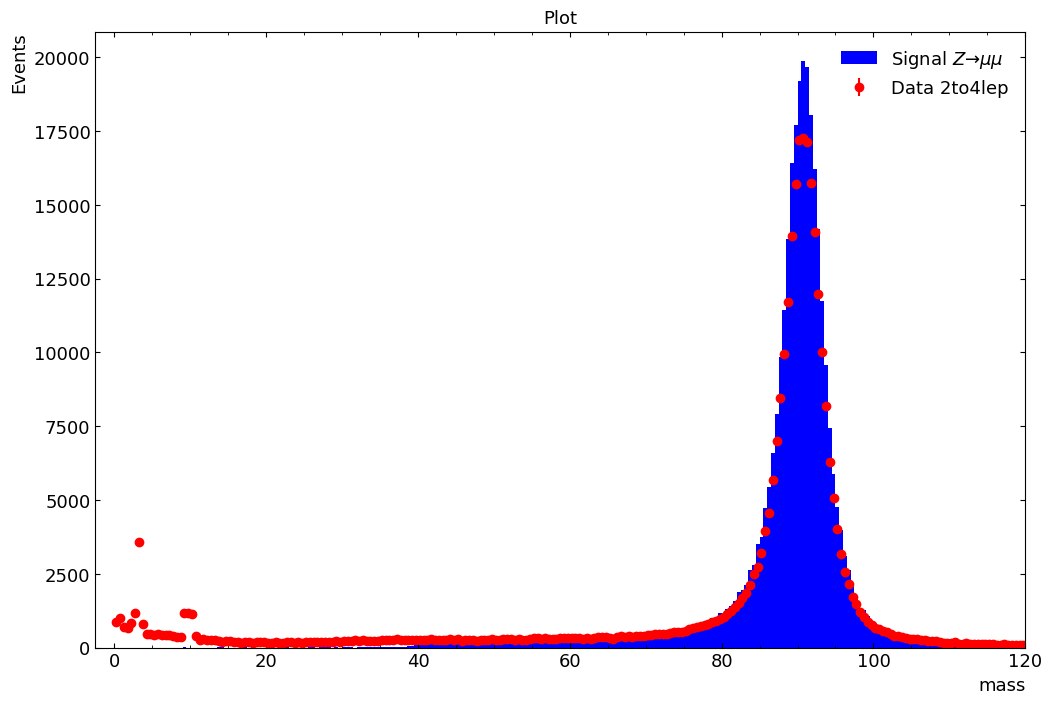

In [9]:
# Single variable is acceptable
plot_histogram_new(run1,
                   ['mass'],
                   ['r', 'b'],
                   (xmin, xmax),
                   0.5,
                   ['mass'],
                   y_label_list=['Events'],
                   title_list=['Plot'])

Elapsed time = 0.2s


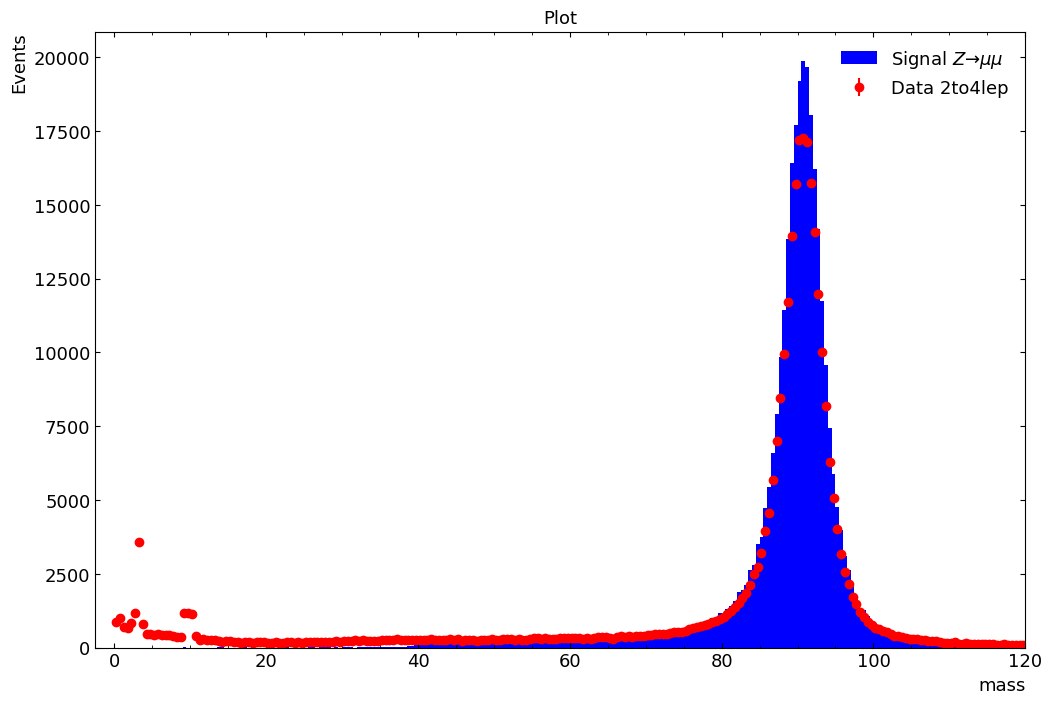

In [10]:
plot_histogram_new(run1,
                   'mass', # Str input is acceptable
                   ['r', 'b'],
                   (xmin, xmax),
                   0.5,
                   'mass', # Str input is acceptable
                   y_label_list='Events', # Str input is acceptable
                   title_list='Plot') # Str input is acceptable

## Demonstrate plotting the same variable using different cuts

In [11]:
## The way is using list of lists
data_list = [run1, run2]
color_lists = [['r', 'b'], ['g', 'k']] # First list is pt0 data and MC, second is pt1 and MC, for example
label_list = ['run1', 'run2']

In [12]:
x = get_results_list(data_list, color_lists, label_list, 'mass')

Elapsed time = 0.2s


<Axes: xlabel='mass', ylabel='Events / 0.5 GeV'>

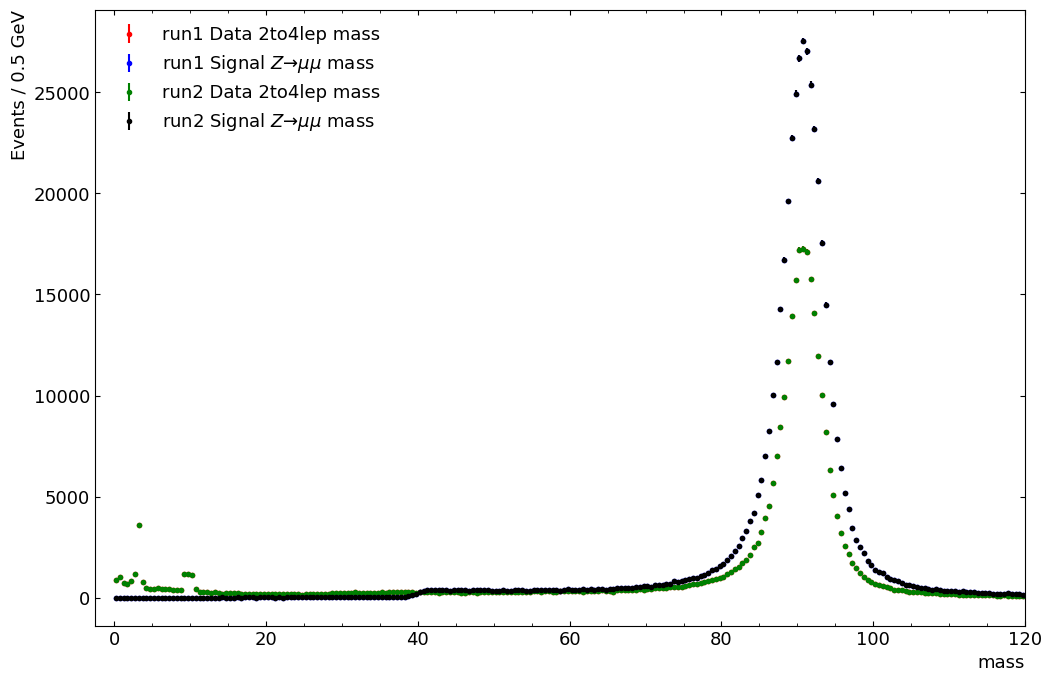

In [13]:
GeV = 1.0
# x-axis range of the plot
xmin = 0 * GeV
xmax = 120 * GeV
# Histogram bin setup
step_size = 0.5 * GeV

plot_multiple_runs(x,
                  xmin,
                  xmax,
                  step_size,
                  'mass',
                  y_label=f'Events / {step_size} GeV', marker='.')